# MultiClass Classification Using GoogleNet

**Author:** [Tarun R Jain](https://twitter.com/TRJ_0751)<br>
**Date created:** 2022/09/03 <br>
**Last modified:** 2022/09/03 <br>
**Description:** Going Deeper with Convolutions (GoogleNet aka Inception-1)

## Introduction

The [ImageNet Large Scale Visual Recognition Challenge (ILSVRC)](https://image-net.org/challenges/LSVRC/) evaluates algorithms for object detection and image classification at large scale. Reseachers at Google introduced a Deep Convolution Neural Network Architecture codenamed "Inception" and named the paper ["Going Deeper with Convolutions"](https://arxiv.org/abs/1409.4842). The main hallmark of this architecture is the improved utilization of the computing resources inside the network. This was achieved by a carefully crafted design that allows for increasing the depth and width of the network while keeping the computational budget constant. To optimize quality, the architectural decisions were based on the Hebbian principle and the intuition of multi-scale processing. One particular incarnation used in our submission for ILSVRC 2014 is called GoogLeNet, a 22 layers deep network, the quality of which is assessed in the context of classification and detection.

Reference: [Paperswithcode](https://paperswithcode.com/paper/going-deeper-with-convolutions)

<div align="center">
<img src="https://miro.medium.com/max/1400/0*Tt7kChwQq2XkcN2q.png">
<p style='text-align:center;'>GoogLeNet incarnation of the Inception architecture</p>
</div>

In [27]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras import models, layers
import datetime

In [28]:
IMAGE_SHAPE = (224,224) #(224,224,3) is the input image shape taken in GoogleNet paper
numEPOCHS = 5 #number of epochs, you can try training for 20 epochs
BATCH_SIZE = 64 #batch size to train the data
CLASS_NUM = 6 #data contains total 6 labels

## Data Collection

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.
Download: [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

In [29]:
TRAIN_DIR = "train" #while you download the dataset, the dir will be named seg_train. You can rename it to train
TEST_DIR = "test"

In [30]:
classLabels = os.listdir(TRAIN_DIR)

In [31]:
print(classLabels) #will display 6 different classes

['street', 'mountain', 'sea', 'forest', 'glacier', 'buildings']


In [32]:
def totalImagesCount(DIR):
    totalImages = 0
    for img in classLabels:
        totalImages+= len(os.listdir(os.path.join(DIR,img)))
    print(f"{DIR} consists of {totalImages} images")

In [33]:
totalImagesCount(TRAIN_DIR)

train consists of 14034 images


In [34]:
totalImagesCount(TEST_DIR)

test consists of 3000 images


The data Consists of `14304` training images and `3000` testing images. A perfect dataset to perform MultiClass Classification

In [35]:
def checkImgLen(DATA_DIR):
    totalImgPerClass = [len(os.listdir(os.path.join(DATA_DIR,overallImg))) for overallImg in classLabels]
    plt.bar(classLabels,totalImgPerClass)

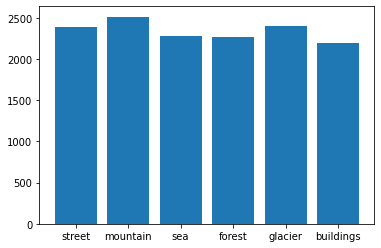

In [36]:
checkImgLen(TRAIN_DIR)

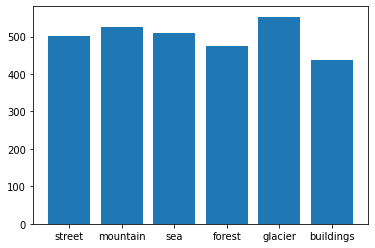

In [37]:
checkImgLen(TEST_DIR)

## Prepare the Data

In [38]:
def prepareData(DATA_DIR,augment=False,shuffle=False):
    """
    Augmentation techniques such as rescaling, rotation and zoom range is performed only on training data.
    On Validation data we only need to rescale the image data. 
    """
    if augment:
        aug = ImageDataGenerator(rescale=1./255,
                                  rotation_range=45,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
    else:
        aug = ImageDataGenerator(rescale=1./255)
        
    #prepare the training data and validation data out of ImageDataGenerator and local directory
    return aug.flow_from_directory(DATA_DIR,
                                   batch_size=BATCH_SIZE,
                                   target_size=IMAGE_SHAPE,
                                   shuffle=shuffle,
                                   class_mode='categorical')

In [39]:
training_data = prepareData(TRAIN_DIR,shuffle=True,augment=True)

Found 14034 images belonging to 6 classes.


In [40]:
validation_data = prepareData(TEST_DIR)

Found 3000 images belonging to 6 classes.


In [41]:
#ImageDataGenerator converts the class indices into one hot encoding to represent each image

In [42]:
print(training_data.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


## Visualize the prepared Data

#### Data Augmentation= True on Training Data

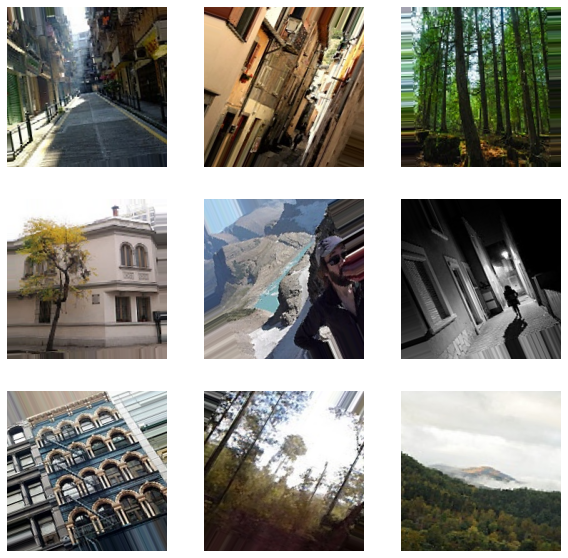

In [43]:
fig = plt.figure(figsize = (10,10))
for i in range(9):
    plt.subplot(3,3, i+1)
    for x,y in training_data:
        img = x[0]
        plt.imshow(img)
        plt.axis('off')
        break

#### Visualization on Validation data along with Labels

The validation data is of type tuple, where first index is image and second label associated to the image.
- To plot the image we shall consider the first index(`image[0]`), since each image is made of `64 batch_size`. 
- To decode the label we shall use `np.argmax`, since label is in form of `One Hot Encoding`.

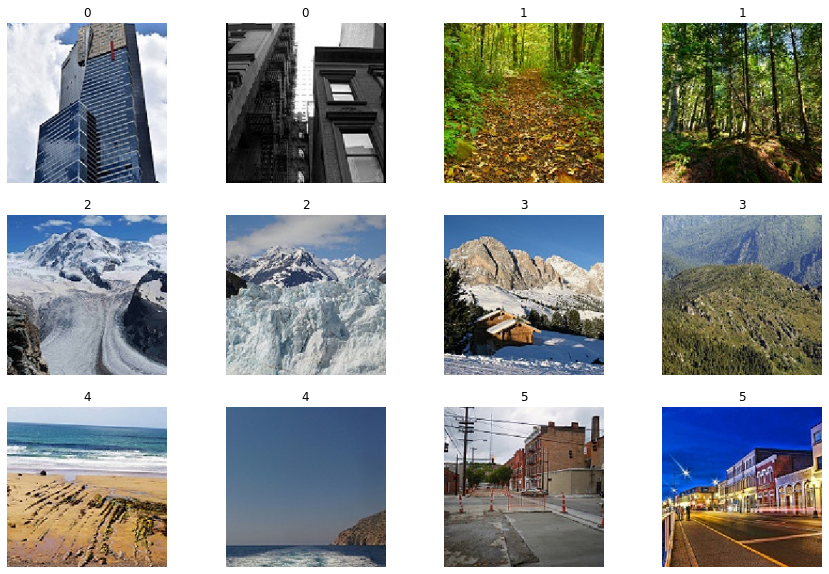

In [44]:
plt.figure(figsize=(15,10))
n = 12
for i in range(n):
    plt.subplot(3,4,i+1)
    validImages,validLabels = validation_data[i+(i*3)]
    plt.imshow(validImages[0])
    decodeLabel = np.argmax(validLabels)
    plt.title(decodeLabel)
    plt.axis("off")

## Build GoogleNet Architecture(Model)

The main idea of the Inception architecture is based on finding out how an optimal local sparse
structure in a convolutional vision network can be approximated and covered by readily available
dense components. 

In [45]:
def inception(_input, filters):
    """
    3a, 3b, 4a, 4b, 4c, 4d, 5a, 5b are inception layers
    Note:
    1. All inception layer should have strides of 1
    2. Same Padding
    3. Depth of 2 i.e., Stack two Conv2D layers
    """
    layer1 = layers.Conv2D(filters[0],(1,1), strides=1, padding='same', activation='relu')(_input)
    
    #In order to avoid patchalignment issues, current incarnations of the Inception architecture are restricted to filter sizes:
    #1×1, 3×3 and 5×5
    
    layer2 = layers.Conv2D(filters[1][0], (1,1), strides=1, padding='same', activation='relu')(_input)
    layer2 = layers.Conv2D(filters[1][1], (3,3), strides=1, padding='same', activation='relu')(layer2)
    
    layer3 = layers.Conv2D(filters[2][0], (1,1), strides=1, padding='same', activation='relu')(_input)
    layer3 = layers.Conv2D(filters[2][1], (5,5), strides=1, padding='same', activation='relu')(layer3)

    layer4 = layers.MaxPooling2D((3,3), strides=1, padding='same')(_input)
    layer4 = layers.Conv2D(filters[3],(1,1), strides=1, padding='same', activation='relu')(layer4)

    return layers.Concatenate(axis=-1)([layer1,layer2,layer3,layer4])

<div align="center">
<img src="https://www.researchgate.net/profile/Ferhat-Ozgur-Catak/publication/342003740/figure/fig2/AS:900073961582598@1591605763849/Inception-module-naive-version-37.jpg">
 <p style='text-align:center;'>Inception module, naive version</p>
</div>

In [46]:
def GoogleNet():
    input_layer = layers.Input(shape=(224,224,3))
    
    layer = layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(input_layer)
    layer = layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = layers.BatchNormalization()(layer)
    
    layer = layers.Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = layers.Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    #after 5th inception layers; apply Average Pooling with (7,7)/1
    layer = layers.AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    #averagepooling is the only layer with valid padding

    layer = layers.Flatten()(layer)
    layer = layers.Dropout(0.4)(layer)
    layer = layers.Dense(units=256, activation='linear')(layer)
    output = layers.Dense(units=CLASS_NUM, activation='softmax')(layer)
    
    model = models.Model(inputs=input_layer, outputs=output)
    
    return model

All the convolutions, including those inside the Inception modules, use rectified linear activation.
The size of the receptive field in our network is 224×224 taking RGB color channels with mean subtraction. “#3×3 reduce” and “#5×5 reduce” stands for the number of 1×1 filters in the reduction
layer used before the 3×3 and 5×5 convolutions

In [49]:
model = GoogleNet()

In [50]:
#cross check the GoogleNet Architecture with model.summary()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv2d_57[0][0]']              
 )                                                                                          

 concatenate_11 (Concatenate)   (None, 14, 14, 512)  0           ['conv2d_72[0][0]',              
                                                                  'conv2d_74[0][0]',              
                                                                  'conv2d_76[0][0]',              
                                                                  'conv2d_77[0][0]']              
                                                                                                  
 conv2d_79 (Conv2D)             (None, 14, 14, 112)  57456       ['concatenate_11[0][0]']         
                                                                                                  
 conv2d_81 (Conv2D)             (None, 14, 14, 24)   12312       ['concatenate_11[0][0]']         
                                                                                                  
 max_pooling2d_19 (MaxPooling2D  (None, 14, 14, 512)  0          ['concatenate_11[0][0]']         
 )        

                                                                  'conv2d_101[0][0]']             
                                                                                                  
 max_pooling2d_23 (MaxPooling2D  (None, 7, 7, 832)   0           ['concatenate_15[0][0]']         
 )                                                                                                
                                                                                                  
 conv2d_103 (Conv2D)            (None, 7, 7, 160)    133280      ['max_pooling2d_23[0][0]']       
                                                                                                  
 conv2d_105 (Conv2D)            (None, 7, 7, 32)     26656       ['max_pooling2d_23[0][0]']       
                                                                                                  
 max_pooling2d_24 (MaxPooling2D  (None, 7, 7, 832)   0           ['max_pooling2d_23[0][0]']       
 )        

## Train the Model

In [53]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [52]:
chk_path = 'model.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = keras.callbacks.ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = keras.callbacks.CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [40]:
history = model.fit(training_data,validation_data=validation_data,epochs=numEPOCHS,steps_per_epoch=100,callbacks=callbacks)

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.8688 - acc: 0.6691
Epoch 1: val_loss improved from 1.68706 to 1.20432, saving model to model.h5
100/100 [==============================] - 554s 6s/step - loss: 0.8688 - acc: 0.6691 - val_loss: 1.2043 - val_acc: 0.6250 - lr: 1.0000e-04
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.8322 - acc: 0.6903
Epoch 2: val_loss improved from 1.20432 to 0.89507, saving model to model.h5
100/100 [==============================] - 548s 5s/step - loss: 0.8322 - acc: 0.6903 - val_loss: 0.8951 - val_acc: 0.6780 - lr: 1.0000e-04
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 0.8000 - acc: 0.7101
Epoch 3: val_loss improved from 0.89507 to 0.80097, saving model to model.h5
100/100 [==============================] - 550s 6s/step - loss: 0.8000 - acc: 0.7101 - val_loss: 0.8010 - val_acc: 0.6920 - lr: 1.0000e-04
Epoch 4/5
100/100 [==============================] - ETA: 0s - loss: 0.7617 - acc:

In [42]:
model.evaluate(validation_data)

47/47 [==============================] - 68s 1s/step - loss: 0.7837 - acc: 0.6990


[0.7836715579032898, 0.6990000009536743]

## Evaluate the Model

In [43]:
predict = model.predict(validation_data)

47/47 [==============================] - 71s 2s/step


In [48]:
def plotAccNLoss(history):
    fig , ax = plt.subplots(1,2)
    fig.set_size_inches(12,4)

    ax[0].plot(history.history['acc'])
    ax[0].plot(history.history['val_acc'])
    ax[0].set_title('Training Accuracy vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Training Loss vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')

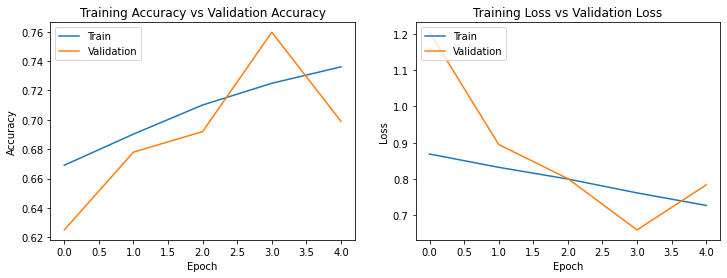

In [49]:
plotAccNLoss(history)

Our training data has smoothly worked properly, training on 15 epochs can easily touch 90% Accuracy, GoogleNet is a powerful Convolution Networks that works well with Multi Class Classification and Object Detection.

## Visualize Predicted Results

In [138]:
labelDict = {}
for k,v in validation_data.class_indices.items():
    labelDict[v] = k

1/1 [==============================] - 0s 42ms/step


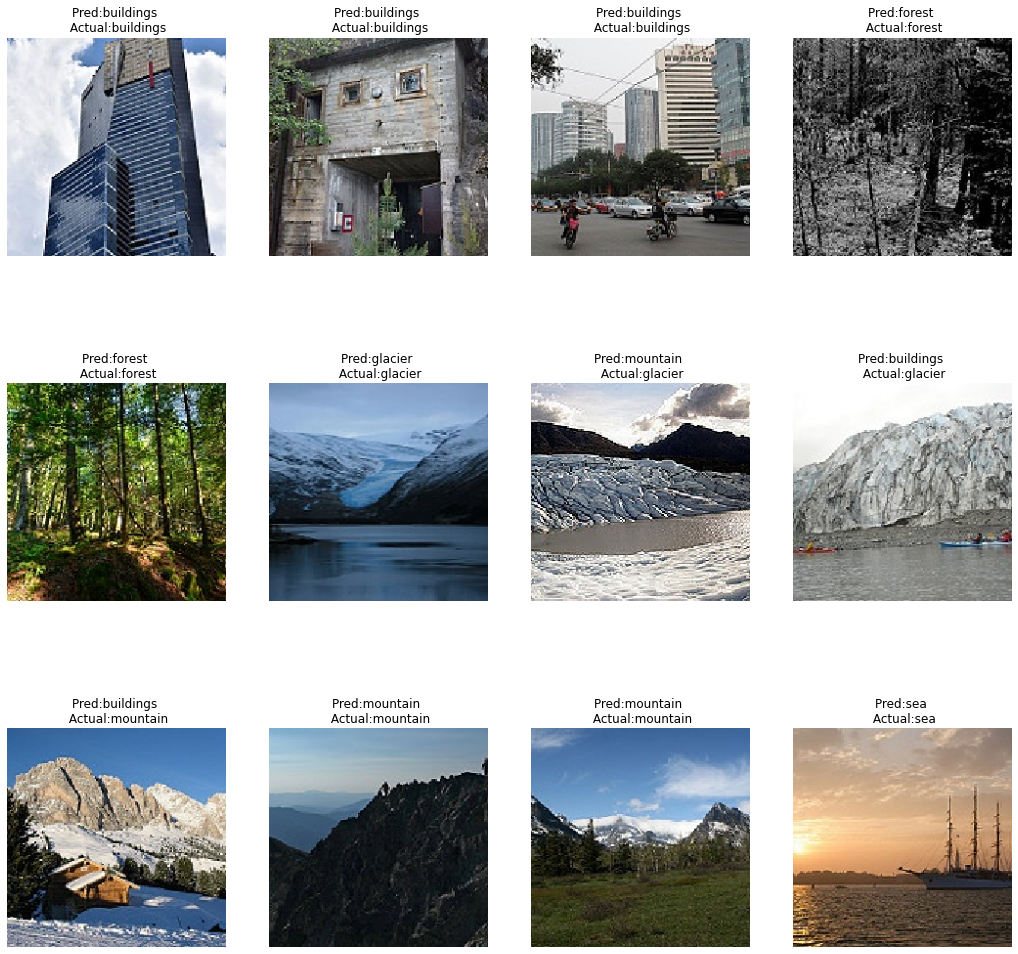

In [141]:
plt.figure(figsize=(18,18))
for i in range(12):
    plt.subplot(3,4,i+1)
    toPredict = validation_data[i+(i*2)]
    imageToPredict,predictedLabel = toPredict
    
    fixImage = np.expand_dims(imageToPredict[0],axis=0)
    fixLabel = np.argmax(predictedLabel)
    target = np.argmax(model.predict(fixImage))
    plt.imshow(imageToPredict[0])
    plt.axis("off")
    
    target = labelDict[target]
    fixLabel = labelDict[fixLabel]
    plt.title(f"Pred:{target} \n Actual:{fixLabel}")

## Final Thoughts

<div>
<img src="https://i.kym-cdn.com/photos/images/newsfeed/000/531/557/a88.jpg">
</div>

The main advantage of this method is a significant quality gain at a modest increase of computational requirements compared to shallower and less wide networks. GoogleNet Conv results seem to yield a solid evidence that approximating the expected optimal sparse structure by readily available dense building blocks is a viable method for improving neural networks for computer vision.

Read complete Paper: [GoogleNet Implementation](https://arxiv.org/pdf/1409.4842v1.pdf)